### MCAのデータをフィッティング

データをインポートする関数

In [1]:
TH1D* importHist(std::string fname)
{

  // １次元ヒストグラムの定義
  auto *hist = new TH1D("h100",";channel;entries",1024,0,1024);
  //  auto *hist = new TH1D("h100","Title",1024,0,1024);
  std::ifstream infile(fname);

  // データコンテナを確保
  std::vector<std::pair<int,int>> var;

  // ファイルから一行づつ読み込み
  int index = 0;
  for (string line = ""; getline(infile, line);++index)
    {
      // std::cout << line << std::endl;
      int  num = std::atoi(line.c_str());
      var.push_back(std::make_pair(index+1,num));
    }
  // std::cout << "size " <<  var.size() << std::endl;

  // ヒストグラムにデータをフィル
  for (const auto & v : var){
    hist->SetBinContent(v.first+1, v.second);
  }
  // TH1Dのポインタを返す
  return hist;
}

リビンする関数

In [2]:
TH1D* rebin(TH1D *hist, int ndiv = 1, std::string title="")
{
  // rebining
  TH1D *hist_rebin = (TH1D *)hist->Rebin(ndiv,title.c_str());
  return hist_rebin;
}


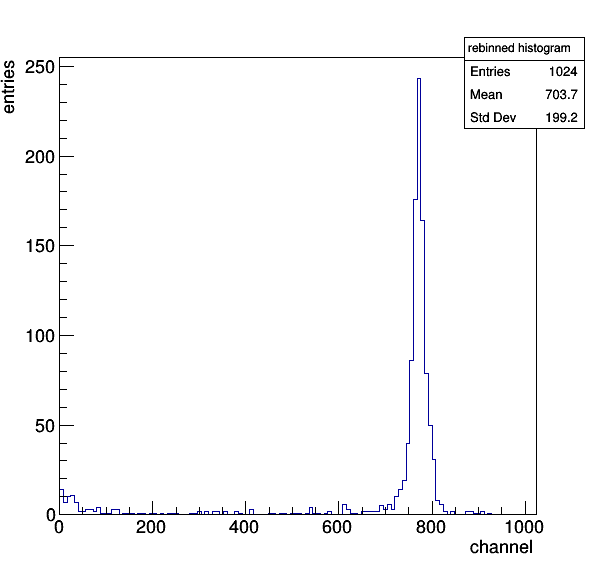

In [3]:
c = new TCanvas("can","",600,600);
auto h = importHist("test.dat");
auto hRebin = rebin(h,8,"rebinned histogram");
hRebin->Draw();
c->Draw();

ガウス関数を定義  
第一引数xが変数、第２引数parはパラメータの配列。  
par[0]はエントリーの数、par[1]が中心値、par[2]がシグマ。  
ここで`TMath::Gaus()`の第四引数の`kTRUE`によって規格化されている(/$\sqrt{2\pi}\sigma$)。

In [4]:
Double_t gaus(Double_t *x, Double_t *par) {
  return par[0]*TMath::Gaus(x[0], par[1], par[2], kTRUE); // normalized gaus
}

In [5]:
auto sg = new TF1("sg",gaus,600,1000,3 );

In [6]:
sg->SetParameters(1000,770,50);

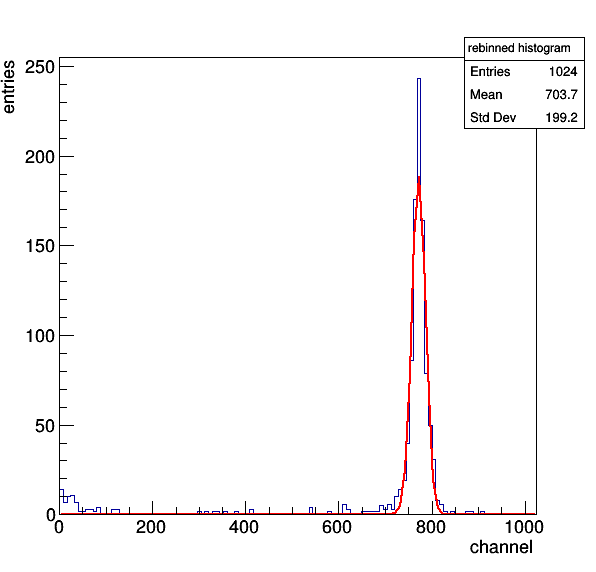

 FCN=223.859 FROM MIGRAD    STATUS=CONVERGED      90 CALLS          91 TOTAL
                     EDM=3.90961e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.98527e+03   2.36396e+02   1.72944e+00  -7.18577e-08
   2  p1           7.72226e+02   5.06086e-01   3.66539e-03   8.09998e-04
   3  p2           1.47991e+01   5.75202e-01   4.16660e-03  -1.46707e-03


In [7]:
hRebin->Fit("sg");
hRebin->Draw();
c->Draw();

フィッティングによりエントリー数を取得する。  
ここでヒストグラムは8channe/binなのでfittingで得られた値の1/8しなければならないことに注意。

In [8]:
double Y = sg->GetParameter(0)/8;
double dY = sg->GetParError(0)/8;
std::cout << Y << "+/-" << dY << std::endl;


873.158+/-29.5496


次にデータをdouble gaussianでfittingしてみる。　　
関数は以下の通り。  
中心が同じでシグマが異なる２つのガウス関数の和として定義する。  
par[4]はg1, g2の比を与えるものであり、$0 < {\rm par}[4] < 1$。  
したがって$\int (g1+g2) dx = 1$に規格化されている。

In [9]:
Double_t doubleGaus(Double_t *x, Double_t *par){
  double g1 = TMath::Gaus(x[0], par[1], par[2], kTRUE); 
  double g2 = TMath::Gaus(x[0], par[1], par[3], kTRUE); 
  return par[0]*(par[4]*g1+(1-par[4])*g2);
}



In [10]:
auto dg = new TF1("dg",doubleGaus,600,1000,5);
  dg->SetParameters(1000,770,15,50,0.8);
  hRebin->Fit("dg");

 FCN=172.582 FROM MIGRAD    STATUS=CONVERGED     166 CALLS         167 TOTAL
                     EDM=3.84262e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.40562e+03   2.41757e+02  -4.18553e-01  -1.65908e-06
   2  p1           7.71651e+02   4.69808e-01  -5.04553e-04   7.11246e-04
   3  p2           2.27296e+01   2.38647e+00   1.27828e-02  -7.91593e-04
   4  p3           8.87223e+00   1.17305e+00   8.57026e-03  -7.80605e-04
   5  p4           4.77846e-01   1.04573e-01  -5.86051e-04  -1.76855e-02


In [11]:
Y = dg->GetParameter(0)/8;
dY = dg->GetParError(0)/8;
std::cout << Y << "+/-" << dY << std::endl;


925.702+/-30.2196


全ての結果を表示させる。


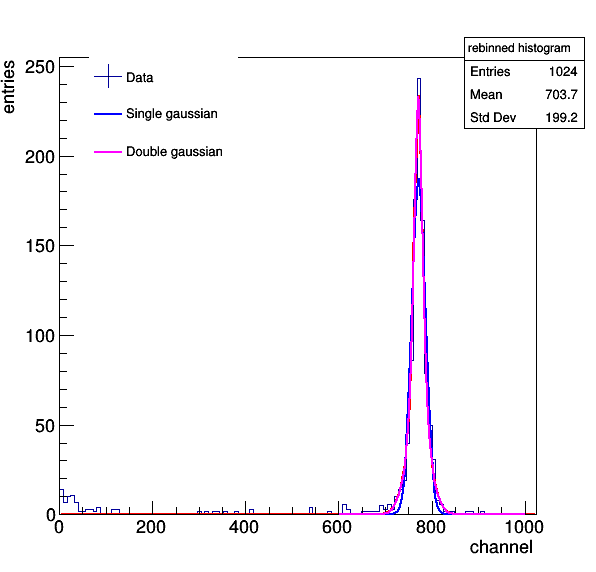

In [12]:
hRebin->Draw();
sg->SetLineColor(kBlue);
sg->Draw("same");
dg->SetLineColor(kMagenta);
dg->Draw("same");
auto leg = new TLegend(0.15,0.7,0.4,0.9,"","NDC");
leg->SetBorderSize(0);
leg->AddEntry(hRebin,"Data","lep");
leg->AddEntry(sg,"Single gaussian","l");
leg->AddEntry(dg,"Double gaussian","l");
leg->Draw();
c->Draw();
